# 1-3: New Approach

We'll adjust our approach somewhat to see if we can get better results 

New in 1-3:

# Imports & Setup

In [1]:
# System filepath setup
import sys

# add data folders to path
sys.path.insert(1, '../data')
sys.path.insert(1, '../src')
sys.path.insert(1, '../img')

# check local filepath

In [2]:
ls ../data/rfcx-species-audio-detection/

sample_submission.csv  tfrecords/             train_fp.csv
test/                  train/                 train_tp.csv


In [3]:
# these libraries are not typically part of the Tensorflow Jupyter container

# ! pip install soundfile
# ! pip install librosa

In [4]:
# ! pip3 install --upgrade pandas

In [5]:
import pandas as pd
print(pd.__version__)

import numpy as np

# matplotlib imports
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

# # Librosa ended up fulfilling most of our audio needs
# soundfile import
# import soundfile as sf

# librosa imports
import librosa
import librosa.display

# for displaying playback
import IPython.display as ipd

from math import floor
from math import ceil

# set seed for random generation
seed = 42

1.2.4


In [6]:
# sklearn imports
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

In [7]:
# STFT Imports

from scipy.signal import stft
from scipy.signal import istft
from scipy.io import wavfile

# Convert one audio file to numpy array

- Soundfile library is capable of reading `.flac` files
- Each file is 60 seconds of 48k mono audio
- soundfile returns mono data as 1D numpy array

In [8]:
# check relative location for sample training audio file
! ls ../data/rfcx-species-audio-detection/train/003bec244.flac

../data/rfcx-species-audio-detection/train/003bec244.flac


### Librosa test

In [9]:
# the original files were sampled at 48000 samples per second.
# we'll downsample these to 22050 and save this as our new sample rate (sr)
librosa_test, sr = librosa.load('../data/rfcx-species-audio-detection/train/003bec244.flac',
                                sr=22050)

In [10]:
type(librosa_test)

numpy.ndarray

In [11]:
print(librosa_test.shape)
print(librosa_test.shape[0]/sr) # 60 seconds of audio at 22050 samples/sec (sps)
librosa_test

(1323000,)
60.0


array([ 0.01167285,  0.02654247, -0.00728239, ..., -0.00921295,
       -0.00755721, -0.00239363], dtype=float32)

In [12]:
# librosa_test sample rate
sr

22050

# Initial graphics

Resource:
- [Learning from Audio Fourier Transformations](https://towardsdatascience.com/learning-from-audio-fourier-transformations-f000124675ee) 

### Visualize Waveform (Full Length, 1 minute)

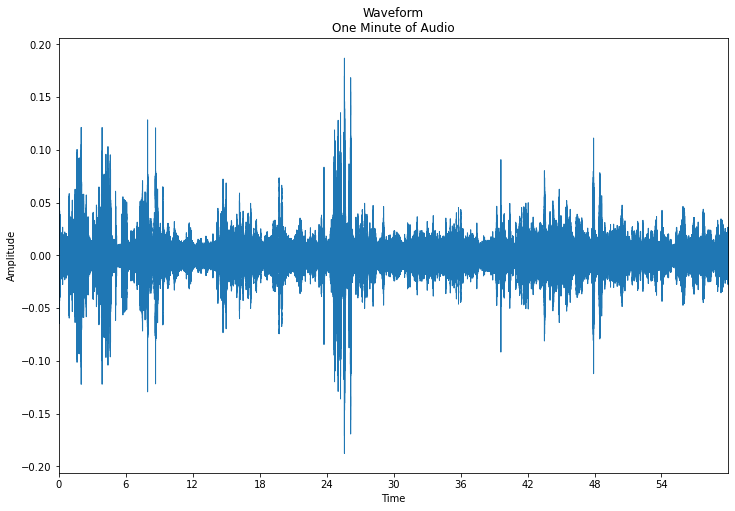

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12, 8))

librosa.display.waveplot(librosa_test, sr=sr)
plt.title("Waveform\nOne Minute of Audio")

plt.ylabel('Amplitude')

plt.savefig('waveform-one_minute.jpg')

plt.show()

### Playback of an Individual File (Full Length: 60s)

In [14]:
# listen to full soundfile...
ipd.Audio(librosa_test, 
          rate=sr)

### Visualize Waveform (one second)

(22050,)


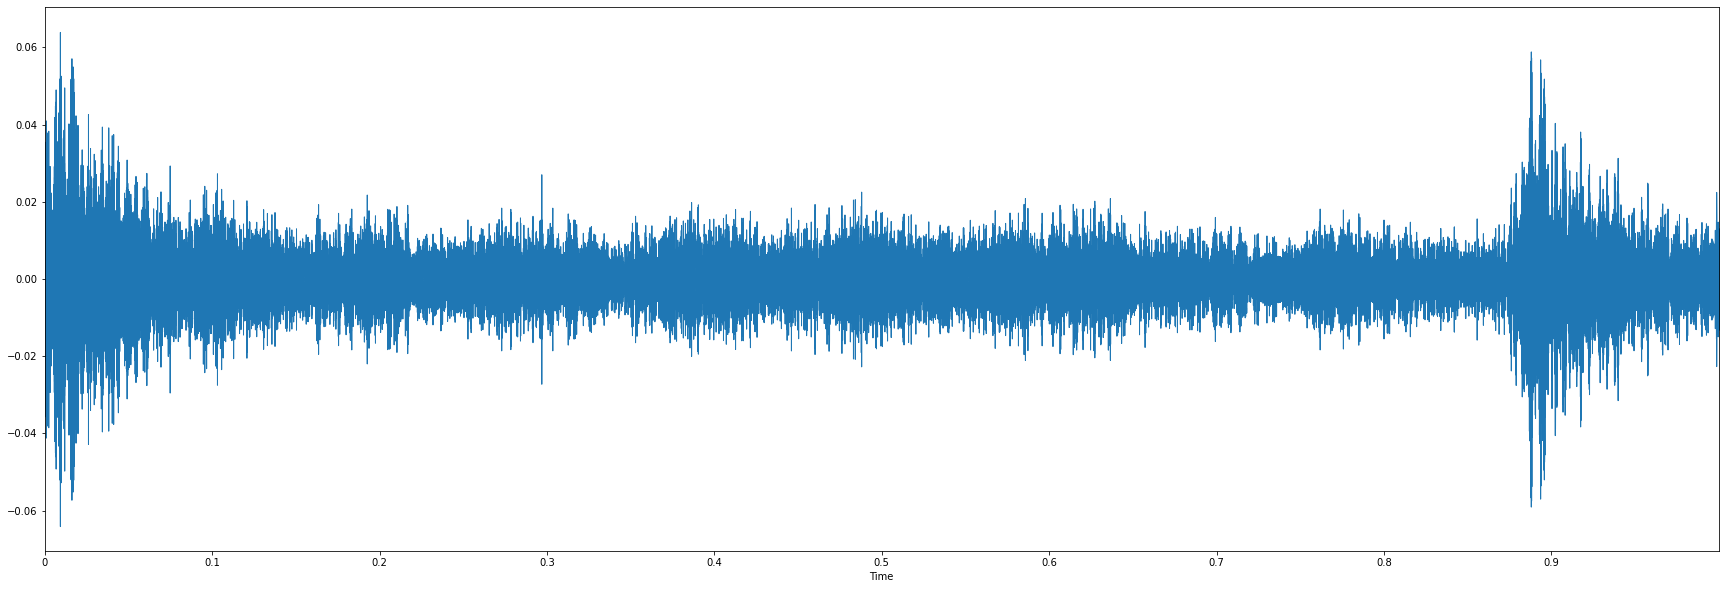

In [15]:
# Visualize waveform for first second

print(librosa_test[:sr].shape)

fig, ax = plt.subplots(1,1, figsize=(30, 10))

librosa.display.waveplot(librosa_test[:sr], sr=sr)

plt.show()

# Exploring True Positive Data

In [16]:
tp_path = '../data/rfcx-species-audio-detection/train_tp.csv'

tp_df = pd.read_csv(tp_path)

In [17]:
tp_df.head()

recording_id  species_id  songtype_id    t_min     f_min    t_max     f_max
0    003bec244          14            1  44.5440  2531.250  45.1307   5531.25
1    006ab765f          23            1  39.9615  7235.160  46.0452  11283.40
2    007f87ba2          12            1  39.1360   562.500  42.2720   3281.25
3    0099c367b          17            4  51.4206  1464.260  55.1996   4565.04
4    009b760e6          10            1  50.0854   947.461  52.5293  10852.70

In [18]:
tp_df[tp_df['recording_id'] == '003bec244']  # 00204008d

recording_id  species_id  songtype_id   t_min    f_min    t_max    f_max
0    003bec244          14            1  44.544  2531.25  45.1307  5531.25

## Unique Values in TP DataFrame

- Unique Recordings in True Positive Data: 1132

```
recording_id    1132
species_id        24
songtype_id        2
t_min           1162
f_min             27
t_max           1167
f_max             32
dtype: int64
```

In [19]:
# uniques for True Positives
print(tp_df.nunique(axis='rows'), "\n")
print(f"{tp_df.shape[0]} rows, {tp_df.shape[1]} columns")

recording_id    1132
species_id        24
songtype_id        2
t_min           1162
f_min             27
t_max           1167
f_max             32
dtype: int64 

1216 rows, 7 columns


## Unique TP Samples per Species

In [20]:
# number of unique tp samples per species

for n in sorted(tp_df['species_id'].unique()):
    print(f"Species {n}, ", len(tp_df[tp_df['species_id'] == n]), "true positive samples")


Species 0,  50 true positive samples
Species 1,  50 true positive samples
Species 2,  37 true positive samples
Species 3,  50 true positive samples
Species 4,  50 true positive samples
Species 5,  50 true positive samples
Species 6,  50 true positive samples
Species 7,  50 true positive samples
Species 8,  50 true positive samples
Species 9,  34 true positive samples
Species 10,  50 true positive samples
Species 11,  50 true positive samples
Species 12,  50 true positive samples
Species 13,  50 true positive samples
Species 14,  50 true positive samples
Species 15,  50 true positive samples
Species 16,  50 true positive samples
Species 17,  68 true positive samples
Species 18,  50 true positive samples
Species 19,  43 true positive samples
Species 20,  40 true positive samples
Species 21,  50 true positive samples
Species 22,  44 true positive samples
Species 23,  100 true positive samples


## Highest & Lowest Relevant Frequency (Global)

In [21]:
freq_max = tp_df['f_max'][tp_df['f_max'].argmax()]
freq_max

freq_min = tp_df['f_min'][tp_df['f_min'].argmin()]
print(f"highest relevant frequency: {freq_max}, lowest relevant frequency: {freq_min}")

highest relevant frequency: 13687.5, lowest relevant frequency: 93.75


### Lowest & Highest Frequency for Each Species in TP

In [22]:
for n in sorted(tp_df['species_id'].unique()):
    species_min = tp_df[tp_df['species_id'] == n]['f_min'].min()
    species_max = tp_df[tp_df['species_id'] == n]['f_max'].max()
    
    print(f"Species{n :3}, {species_min :>10.2f} minimum frequency, {species_max :>10.2f} maximum frequency")

Species  0,    5906.25 minimum frequency,    8250.00 maximum frequency
Species  1,    3843.75 minimum frequency,    5625.00 maximum frequency
Species  2,     468.75 minimum frequency,    3000.00 maximum frequency
Species  3,    1031.25 minimum frequency,    2812.50 maximum frequency
Species  4,    2343.75 minimum frequency,    4218.75 maximum frequency
Species  5,    4781.25 minimum frequency,   11250.00 maximum frequency
Species  6,     562.50 minimum frequency,    4406.25 maximum frequency
Species  7,    4687.50 minimum frequency,   11437.50 maximum frequency
Species  8,    3750.00 minimum frequency,    5531.25 maximum frequency
Species  9,     843.75 minimum frequency,    5718.75 maximum frequency
Species 10,     947.46 minimum frequency,   10852.70 maximum frequency
Species 11,    1808.79 minimum frequency,    5684.77 maximum frequency
Species 12,     562.50 minimum frequency,    3281.25 maximum frequency
Species 13,      93.75 minimum frequency,    1406.25 maximum frequency
Specie

## Maximum length of TP sample

In [23]:
# max length 
for n in sorted(tp_df['species_id'].unique()):
    species_time_min = (tp_df[tp_df['species_id'] == n]['t_max'] - tp_df[tp_df['species_id'] == n]['t_min']).min()
    species_time_max = (tp_df[tp_df['species_id'] == n]['t_max'] - tp_df[tp_df['species_id'] == n]['t_min']).max()
    
    print(f"Species{n :3}, {species_time_min :10.5f} minimum time length, {species_time_max :10.5f} maximum time length")

Species  0,    0.79460 minimum time length,    1.29070 maximum time length
Species  1,    0.89600 minimum time length,    0.89600 maximum time length
Species  2,    1.77600 minimum time length,    1.77600 maximum time length
Species  3,    0.74130 minimum time length,    0.74140 maximum time length
Species  4,    1.85600 minimum time length,    2.18670 maximum time length
Species  5,    2.35200 minimum time length,    3.10930 maximum time length
Species  6,    2.02130 minimum time length,    2.14400 maximum time length
Species  7,    3.14130 minimum time length,    3.14140 maximum time length
Species  8,    4.12260 minimum time length,    4.12270 maximum time length
Species  9,    2.80530 minimum time length,    3.56270 maximum time length
Species 10,    2.44380 minimum time length,    2.44390 maximum time length
Species 11,    1.13770 minimum time length,    1.13780 maximum time length
Species 12,    3.13600 minimum time length,    3.13600 maximum time length
Species 13,    0.62400 mi

In [24]:
# Longest TP sample (species 23)
(tp_df['t_max']-tp_df['t_min']).max()

7.923900000000003

In [25]:
# Shortestt TP sample 
(tp_df['t_max']-tp_df['t_min']).min()

0.27199999999999847

# Create and Check a True Positive Test Slice (Species 14)

In [26]:
# Summary of file to check
print(tp_df.iloc[0])

recording_id    003bec244
species_id             14
songtype_id             1
t_min              44.544
f_min             2531.25
t_max             45.1307
f_max             5531.25
Name: 0, dtype: object


In [27]:
## get in and out points

# time in seconds multiplied by sample rate

test_tp_in = int(tp_df.iloc[0]['t_min'] * sr)

test_tp_out = int(tp_df.iloc[0]['t_max'] * sr)

In [28]:
print(test_tp_in)
print(test_tp_out)

print(test_tp_out - test_tp_in)

982195
995131
12936


In [29]:
test_tp_slice = librosa_test[test_tp_in:test_tp_out + 1]

In [30]:
# listen to species_id 14, songtype_id 1 true positive
ipd.Audio(test_tp_slice, 
          rate=sr,
          normalize=True)

In [31]:
pwd

'/Users/christopherkeech/coding_projects/dsi_remote_pt/capstones/rainforest_audio/notebooks'

## Short Time Fourier Transform
- creates frequency distributions
- Try NMF (non zero matrix factorization) to extract frequencies & amplitues over time

In [32]:
# Returns frequency, time
'''
Returns
-------
f : ndarray
    Array of sample frequencies.
t : ndarray
    Array of segment times.
Zxx : ndarray
    STFT of `x`. By default, the last axis of `Zxx` corresponds
    to the segment times.
'''
f, t, Zxx = stft(test_tp_slice, 
                 fs=sr)

In [33]:
print(f"f shape: {f.shape}")
print(f"t shape: {t.shape}")
print(f"Zxx shape: {Zxx.shape}")

f shape: (129,)
t shape: (103,)
Zxx shape: (129, 103)


In [34]:
print(type(Zxx))
print(Zxx.shape)
Zxx
# j imaginary part of complex number...
# sqare and absolute value transforms complex number back to a number in the set of real numbers...

<class 'numpy.ndarray'>
(129, 103)


array([[ 8.6120778e-04+0.0000000e+00j, -6.6569127e-04+0.0000000e+00j,
         3.6050886e-04+0.0000000e+00j, ...,
        -6.1083201e-04+0.0000000e+00j, -6.8513342e-05+0.0000000e+00j,
         2.0697696e-07+0.0000000e+00j],
       [-7.8067032e-04+4.5347158e-04j,  8.0396869e-04-1.6885008e-04j,
        -5.1052618e-04-7.5939187e-04j, ...,
         4.1961644e-04-5.4890820e-06j,  4.7190599e-05-3.8647406e-05j,
         2.0518097e-07-2.9336729e-08j],
       [ 3.4781647e-04-8.5317966e-04j, -1.1485079e-04+3.6847338e-04j,
         3.0103853e-04+1.0450560e-03j, ...,
        -1.4303422e-04+3.3192782e-04j, -1.6829660e-04+8.0218910e-05j,
         1.9980722e-07-5.8298628e-08j],
       ...,
       [-5.9484737e-05+2.1049924e-07j,  6.7065292e-07-9.7809526e-08j,
         1.9162833e-06+4.4030398e-06j, ...,
        -3.7815635e-06+8.8133329e-06j,  1.1962740e-05+5.0287390e-06j,
         3.6805963e-07+1.3348446e-07j],
       [ 6.1207589e-05+4.7116077e-07j, -1.0480918e-06-6.6298082e-07j,
        -5.7710935e-07

In [35]:
Zxx_abs_sq = np.abs(Zxx)**2

In [36]:
print(Zxx_abs_sq)

[[7.4167883e-07 4.4314487e-07 1.2996664e-07 ... 3.7311574e-07
  4.6940780e-09 4.2839464e-14]
 [8.1508261e-07 6.7487599e-07 8.3731294e-07 ... 1.7610810e-07
  3.7205747e-09 4.2959871e-14]
 [8.4889189e-07 1.4896334e-07 1.1827665e-06 ... 1.3063486e-07
  3.4758820e-08 4.3321653e-14]
 ...
 [3.5384782e-09 4.5934204e-13 2.3058900e-11 ... 9.1975053e-11
  1.6839537e-10 1.5328599e-13]
 [3.7465906e-09 1.5380401e-12 2.4954333e-12 ... 8.7655135e-12
  2.3609445e-10 1.5324507e-13]
 [3.8526577e-09 9.9181243e-14 4.3324843e-13 ... 1.2822691e-13
  2.7273572e-10 1.5323172e-13]]


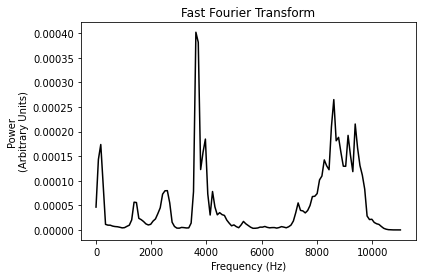

In [37]:
# squared abs value of Zxx
plt.figsize=(12,8)
plt.plot(f, (np.abs(Zxx)**2).sum(1), color='black')

plt.title('Fast Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power\n(Arbitrary Units)')

plt.savefig('fast_fourier_transform.jpg')

ipd.Audio(test_tp_slice,
          rate=sr)

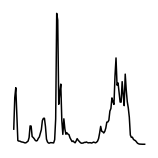

In [38]:
fig = plt.figure(frameon=False)
fig.set_size_inches(2,2)
ax = plt.Axes(fig, [0,0,1,1])
ax.set_axis_off()
fig.add_axes(ax)

ax.plot(f, (np.abs(Zxx)**2).sum(1), c='black')

# plt.savefig(fname='test_figure',
        
#            )
# plt.close(fig)
plt.show()

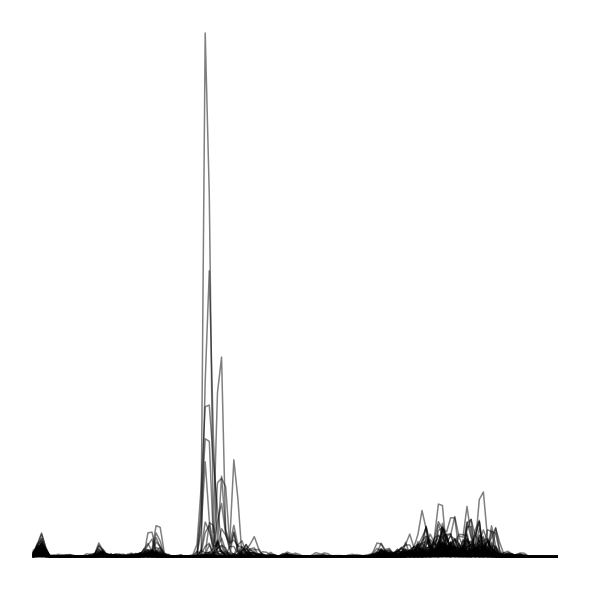

In [39]:
fig = plt.figure(frameon=False)
fig.set_size_inches(8,8)
ax = plt.Axes(fig, [0,0,1,1])
ax.set_axis_off()
fig.add_axes(ax)

ax.plot(f, (np.abs(Zxx)**2), color="black", alpha=0.5)

# plt.savefig(fname='test_figure',
        
#            )
# plt.close(fig)
plt.show()

In [40]:
# help(ax.plot)

In [41]:
plt.show()

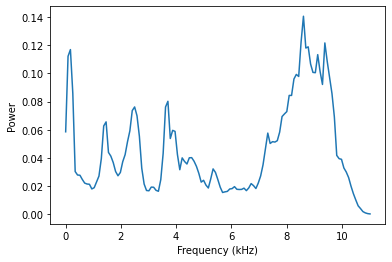

In [42]:
# not squared...
plt.plot(f/1000, (np.abs(Zxx)).sum(1))

plt.xlabel('Frequency (kHz)')
plt.ylabel('Power')

ipd.Audio(test_tp_slice,
          rate=sr)

In [43]:
len(Zxx)

129

In [44]:
Z_min = np.min((np.abs(Zxx)).sum(1))
Z_max = np.max((np.abs(Zxx)).sum(1))

print(Z_min, Z_max)

0.00023026603 0.14051107


Text(0, 0.5, 'Frequency (kHz)')

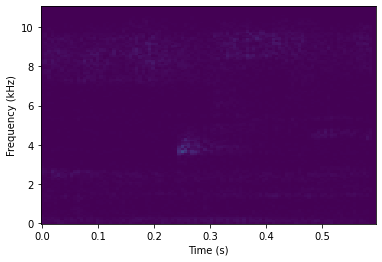

In [45]:
# not squared. signal is very quiet, but does show up in the graph...

# frequency vs time

plt.pcolormesh(t, f/1000, (np.abs(Zxx)), vmin=0, 
               vmax= np.max(test_tp_slice),
               shading='auto',
               cmap='viridis')

plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')


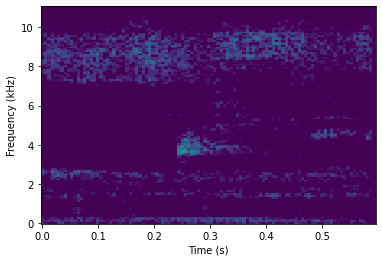

In [46]:
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

# not squared. signal is very quiet, but does show up in the graph...

# frequency vs time

plt.pcolormesh(t, f/1000, np.abs(Zxx) * 2, 
               norm=colors.LogNorm(vmin=.001, vmax=.4),
               shading='auto',
               cmap='viridis')
                                   
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')

plt.show()

CPU times: user 932 ms, sys: 201 ms, total: 1.13 s
Wall time: 508 ms


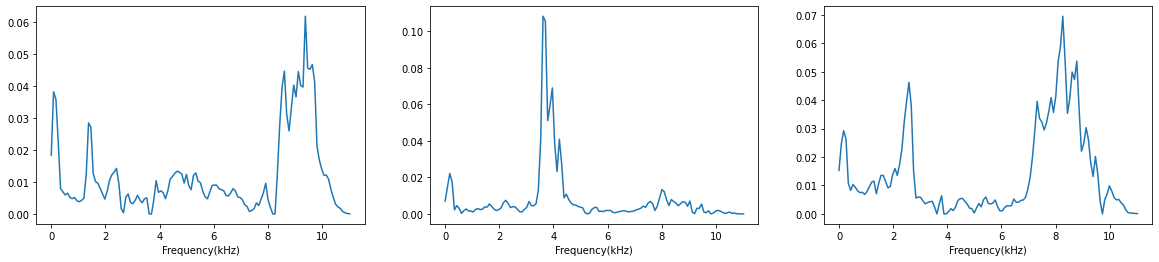

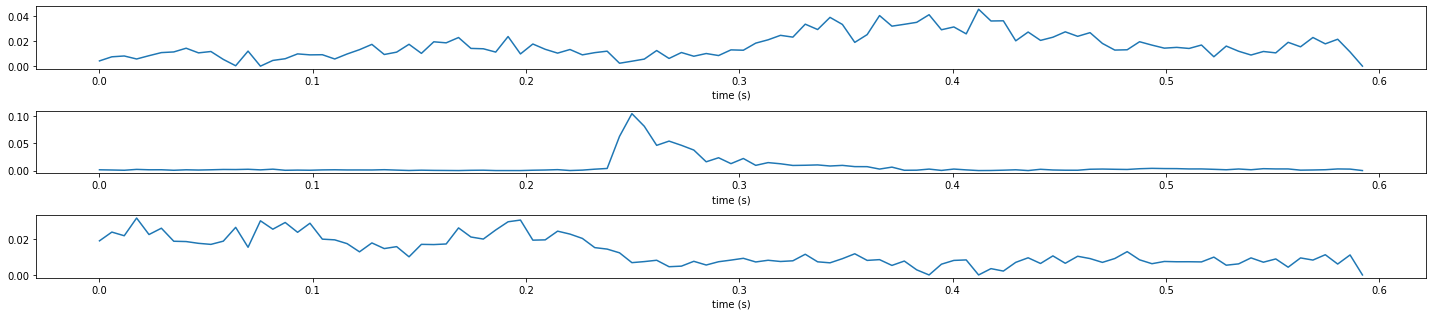

In [47]:
%%time

n_components = 3

test_nmf = NMF(n_components, max_iter=500)
test_W = test_nmf.fit_transform(np.abs(Zxx))
test_H = test_nmf.components_

fig, ax = plt.subplots(1, n_components, figsize=(20,4))

for i in range(n_components):
    ax[i].plot(f/1000, test_W[:, i])
    ax[i].set_xlabel('Frequency(kHz)')
    
fig, ax = plt.subplots(n_components, 1, figsize=(20, n_components*1.5))

for i in range(n_components):
    ax[i].plot(t, test_H.T[:, i])
    ax[i].set_xlabel('time (s)')

fig.tight_layout()

## Spectrogram of test_tp_slice
[Spectrogram Examples](https://www.youtube.com/watch?v=TJGlxdW7Fb4)

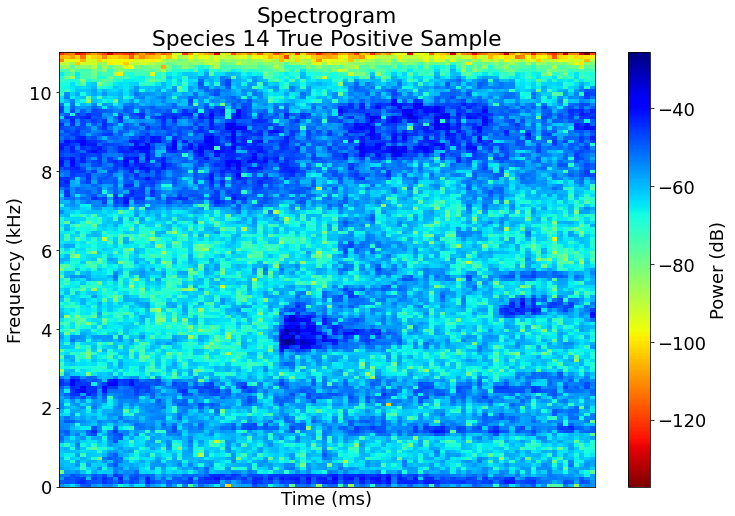

In [48]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 18})
plt.specgram(test_tp_slice, 
             Fs=sr/1000, 
             cmap='jet_r',
             sides='onesided',
             scale='dB')

plt.colorbar(label='Power (dB)')
plt.xticks([])

plt.title("Spectrogram\nSpecies 14 True Positive Sample")
plt.xlabel("Time (ms)")
plt.ylabel("Frequency (kHz)")

plt.show()

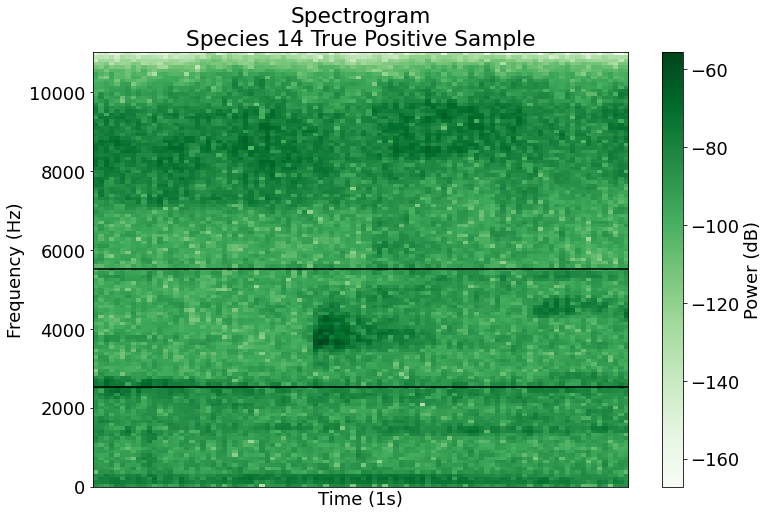

In [49]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 18})
plt.specgram(test_tp_slice, 
             Fs=sr, 
             cmap='Greens',
             sides='onesided',
             scale='dB')

plt.colorbar(label='Power (dB)')

# plot horizontal lines at min and max freq...
# plt.text(x=10, y=tp_df.iloc[0]['f_min'], s='Minimum')
plt.axhline(y=tp_df.iloc[0]['f_min'], color='black', linestyle='-')


plt.axhline(y=tp_df.iloc[0]['f_max'], color='black', linestyle='-')

plt.title("Spectrogram\nSpecies 14 True Positive Sample")
plt.xlabel("Time (1s)")
plt.ylabel("Frequency (Hz)")
plt.xticks([])
plt.savefig('spectrogram.jpg')

plt.show()

In [50]:
# Summary of file to check
print(tp_df.iloc[0])

recording_id    003bec244
species_id             14
songtype_id             1
t_min              44.544
f_min             2531.25
t_max             45.1307
f_max             5531.25
Name: 0, dtype: object


In [51]:
tp_df.iloc[0]['f_min']

2531.25

In [52]:
test_tp_slice.min()

-0.055978943

In [53]:
test_tp_slice.max()

0.06313136

In [54]:
type(test_tp_slice)

numpy.ndarray

In [55]:
print(f.shape)

print(f)

# range_bool = f > tp_df.iloc[0]['f_min'] and f < tp_df.iloc[0]['f_max']
print(tp_df.iloc[0]['f_min'])
print(tp_df.iloc[0]['f_max'])


# this is the idea, but doesn't work
# print(np.where((f > tp_df.iloc[0]['f_min'] and f < tp_df.iloc[0]['f_max'])))

lower_indx_bound = (np.where((f > tp_df.iloc[0]['f_min']))[0][0] - 1) # start at one index lower to include lower frequency bound
upper_indx_bound = (np.where((f < tp_df.iloc[0]['f_max']))[0][-1] + 1) # end at one index further to include upper frequency bound


print(lower_indx_bound, upper_indx_bound)

print(f[lower_indx_bound: upper_indx_bound]) # upper bound should include frequencies from 5437.5-5625 inclusive...


(129,)
[    0.           86.1328125   172.265625    258.3984375   344.53125
   430.6640625   516.796875    602.9296875   689.0625      775.1953125
   861.328125    947.4609375  1033.59375    1119.7265625  1205.859375
  1291.9921875  1378.125      1464.2578125  1550.390625   1636.5234375
  1722.65625    1808.7890625  1894.921875   1981.0546875  2067.1875
  2153.3203125  2239.453125   2325.5859375  2411.71875    2497.8515625
  2583.984375   2670.1171875  2756.25       2842.3828125  2928.515625
  3014.6484375  3100.78125    3186.9140625  3273.046875   3359.1796875
  3445.3125     3531.4453125  3617.578125   3703.7109375  3789.84375
  3875.9765625  3962.109375   4048.2421875  4134.375      4220.5078125
  4306.640625   4392.7734375  4478.90625    4565.0390625  4651.171875
  4737.3046875  4823.4375     4909.5703125  4995.703125   5081.8359375
  5167.96875    5254.1015625  5340.234375   5426.3671875  5512.5
  5598.6328125  5684.765625   5770.8984375  5857.03125    5943.1640625
  6029.296875  

In [56]:
print(t.shape)

(103,)


In [57]:
print(Zxx.shape)

(129, 103)


In [58]:
(Zxx[lower_indx_bound:upper_indx_bound, :]).shape

(36, 103)

Text(0, 0.5, 'Frequency (Hz)')

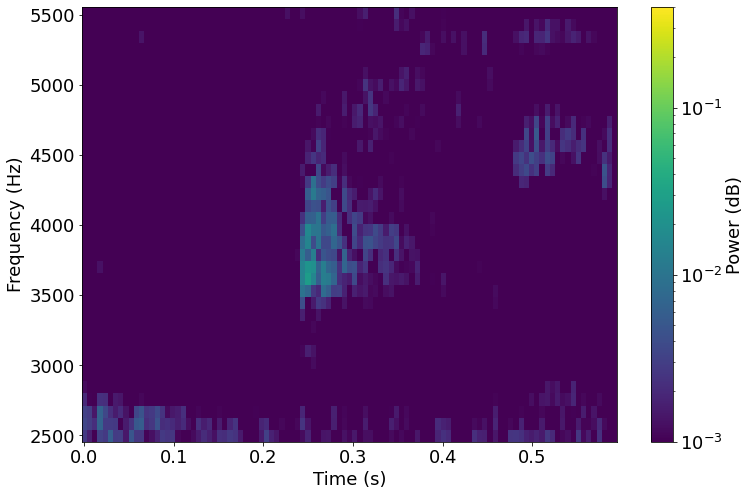

In [59]:
# not squared. signal is very quiet, but does show up in the graph...

# frequency vs time

plt.pcolormesh(t, f[lower_indx_bound: upper_indx_bound], np.abs(Zxx[lower_indx_bound:upper_indx_bound, :]) * 2, 
               norm=colors.LogNorm(vmin=.001, vmax=.4),
               shading='auto',
               cmap='viridis')


plt.colorbar(label='Power (dB)')
                                   
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

# One-Hot Encoding TP DataFrame

In [60]:
print(tp_df.shape)
tp_df.head()

(1216, 7)


recording_id  species_id  songtype_id    t_min     f_min    t_max     f_max
0    003bec244          14            1  44.5440  2531.250  45.1307   5531.25
1    006ab765f          23            1  39.9615  7235.160  46.0452  11283.40
2    007f87ba2          12            1  39.1360   562.500  42.2720   3281.25
3    0099c367b          17            4  51.4206  1464.260  55.1996   4565.04
4    009b760e6          10            1  50.0854   947.461  52.5293  10852.70

In [61]:
tp_df_onehot = pd.get_dummies(tp_df['species_id'], prefix='id', prefix_sep=" ")

In [62]:
tp_df_onehot.head()

id 0  id 1  id 2  id 3  id 4  id 5  id 6  id 7  id 8  id 9  ...  id 14  \
0     0     0     0     0     0     0     0     0     0     0  ...      1   
1     0     0     0     0     0     0     0     0     0     0  ...      0   
2     0     0     0     0     0     0     0     0     0     0  ...      0   
3     0     0     0     0     0     0     0     0     0     0  ...      0   
4     0     0     0     0     0     0     0     0     0     0  ...      0   

   id 15  id 16  id 17  id 18  id 19  id 20  id 21  id 22  id 23  
0      0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0      1  
2      0      0      0      0      0      0      0      0      0  
3      0      0      1      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0      0  

[5 rows x 24 columns]

### Get TP One-Hot Column Headings

In [63]:
# get one hot column headings to use for later
tp_oh_col_headings = list(tp_df_onehot.columns)

for i in tp_oh_col_headings:
    print(i)

id 0
id 1
id 2
id 3
id 4
id 5
id 6
id 7
id 8
id 9
id 10
id 11
id 12
id 13
id 14
id 15
id 16
id 17
id 18
id 19
id 20
id 21
id 22
id 23


In [64]:
# join tp_df datframe with onehot columns
tp_woh = tp_df.join(tp_df_onehot)

In [65]:
# insert column to check tp at a glance
tp_woh.insert(loc=1, column="label_type", value='tp')

In [66]:
tp_woh.head()

recording_id label_type  species_id  songtype_id    t_min     f_min  \
0    003bec244         tp          14            1  44.5440  2531.250   
1    006ab765f         tp          23            1  39.9615  7235.160   
2    007f87ba2         tp          12            1  39.1360   562.500   
3    0099c367b         tp          17            4  51.4206  1464.260   
4    009b760e6         tp          10            1  50.0854   947.461   

     t_max     f_max  id 0  id 1  ...  id 14  id 15  id 16  id 17  id 18  \
0  45.1307   5531.25     0     0  ...      1      0      0      0      0   
1  46.0452  11283.40     0     0  ...      0      0      0      0      0   
2  42.2720   3281.25     0     0  ...      0      0      0      0      0   
3  55.1996   4565.04     0     0  ...      0      0      0      1      0   
4  52.5293  10852.70     0     0  ...      0      0      0      0      0   

   id 19  id 20  id 21  id 22  id 23  
0      0      0      0      0      0  
1      0      0      0      0      1  
2      0      0      0      0      0  
3      0      0      0      0      0  
4      0      0      0      0      0  

[5 rows x 32 columns]

# Tensorflow: Getting Audio Natively via Tensorflow_io

- [decode FLAC](https://www.tensorflow.org/io/api_docs/python/tfio/audio/decode_flac)  
- [tensorflow_io: Audio](https://www.tensorflow.org/io/tutorials/audio)  

In [67]:
import tensorflow as tf
import tensorflow_io as tfio

# check versions
print(f"tensorflow verison:    {tf.version.VERSION :>6}")
print(f"tensorflow_io verison: {tfio.version.VERSION :>6}")

tensorflow verison:     2.4.1
tensorflow_io verison: 0.17.1


In [68]:
test_path = '../data/rfcx-species-audio-detection/train/003bec244.flac'

In [69]:
# get full auido file
audio_test = tfio.audio.AudioIOTensor(filename=test_path)
tf_sr = audio_test.rate.numpy()

In [70]:
print(audio_test)

<AudioIOTensor: shape=[2880000       1], dtype=<dtype: 'int16'>, rate=48000>


In [71]:
audio_test.shape.numpy().shape

(2,)

In [72]:
start = int(tp_df.iloc[0]['t_min'] * sr)

stop = int(tp_df.iloc[0]['t_max'] * sr)

In [73]:
audio_slice = audio_test[start:stop]

In [74]:
print(audio_slice.shape)
print(audio_slice.shape[0]/tf_sr) # 0.2695 seconds
print(audio_slice[1]) # ???

(12936, 1)
0.2695
tf.Tensor([-536], shape=(1,), dtype=int16)


In [75]:
audio_tensor = tf.squeeze(audio_slice, axis=[-1])
audio_tensor

<tf.Tensor: shape=(12936,), dtype=int16, numpy=array([-222, -536,  -33, ..., -104,   87,  122], dtype=int16)>

In [76]:
from IPython.display import Audio
Audio(audio_tensor.numpy(), rate=audio_test.rate.numpy())

In [77]:
audio_tensor.numpy().shape

(12936,)

In [78]:
# get tp slice of audio file
test_slice = tfio.audio.AudioIOTensor(
    filename = test_path)

In [79]:
test_slice.__len__()

<tf.Tensor: shape=(), dtype=int64, numpy=2880000>

<class 'numpy.ndarray'>
(51, 257)
[[ 2396.5613    3871.4338    5481.7705   ...   885.3622    1410.5768
   1550.6182  ]
 [  551.8537    6723.602    11038.1875   ...   388.0654     417.67883
     18.825073]
 [10329.732    10475.577     5620.459    ...  2249.62      1548.6443
   1279.148   ]
 ...
 [ 5475.523     6794.5693    4939.0293   ...   653.6434     647.2723
    486.29053 ]
 [ 9600.4       9194.207     7372.9014   ...   334.97253    324.85333
    559.2095  ]
 [  989.3697     956.86707    862.4075   ...   114.60333     94.12807
     86.84235 ]]


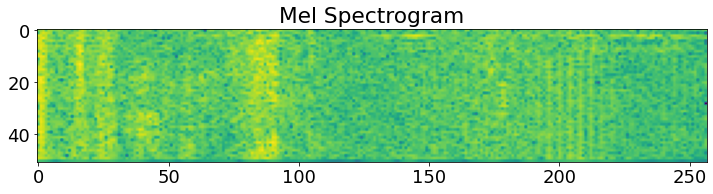

In [80]:
audio_slice = audio_test[start: stop-1]
audio_tensor = tf.squeeze(audio_slice, axis=[-1])
tensor = tf.cast(audio_tensor, tf.float32)

spectrogram = tfio.experimental.audio.spectrogram(
    tensor,
    nfft=512,
    window=512,
    stride=256
)

print(type(spectrogram.numpy()))

print((spectrogram.numpy().shape))


print(spectrogram.numpy())
# plt.figure()
plt.figsize=(12, 8)
plt.imshow(tf.math.log(spectrogram).numpy())
plt.title('Mel Spectrogram')
plt.show()

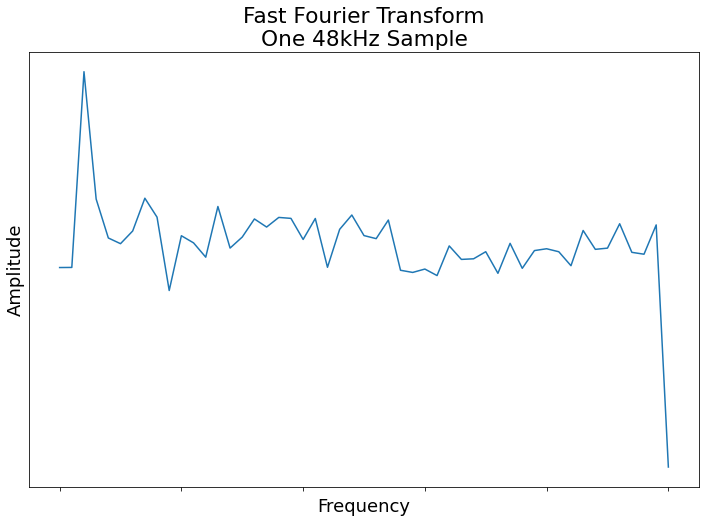

In [81]:
plt.figsize=(12, 8)
plt.plot(spectrogram.numpy().sum(1))
plt.title("Fast Fourier Transform\nOne 48kHz Sample") # fast fourier transform
plt.xlabel("Frequency")
plt.ylabel("Amplitude")

plt.yticks([])
plt.xticks([0,10,20,30,40,50],["","","","","",""])
plt.savefig('fast_fourier_one_sample.jpg')
plt.show()

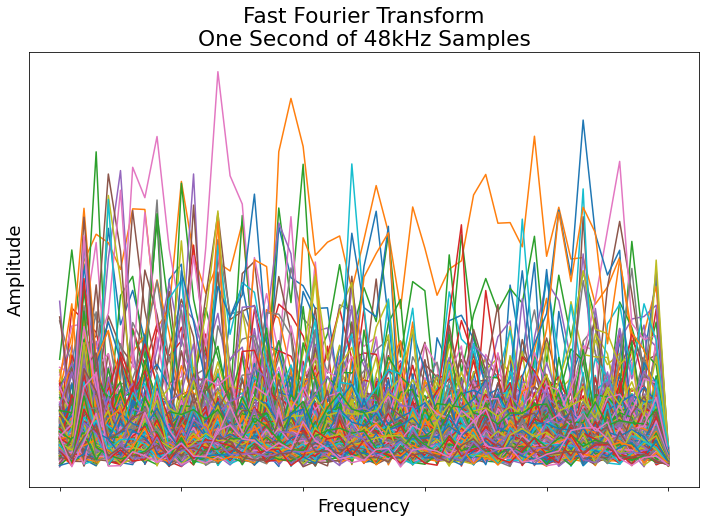

In [82]:
plt.figsize=(8, 10)
plt.plot(spectrogram.numpy())
plt.title("Fast Fourier Transform\nOne Second of 48kHz Samples") # fast fourier transform
plt.xlabel("Frequency")
plt.ylabel("Amplitude")

plt.yticks([])
plt.xticks([0,10,20,30,40,50],["","","","","",""])
plt.savefig('fast_fourier_one_second.jpg')
plt.show()

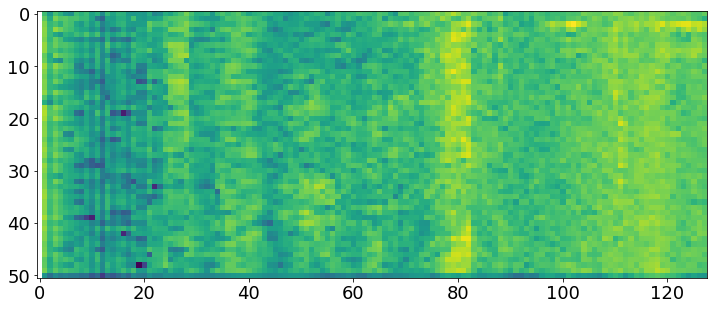

In [83]:
mel_spectrogram = tfio.experimental.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000
)

plt.figure
plt.imshow(tf.math.log(mel_spectrogram).numpy())

plt.show()

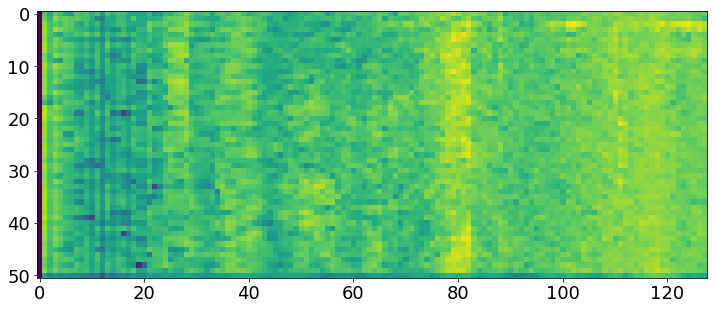

In [84]:
dbscale_mel_spectrogram = tfio.experimental.audio.dbscale(
    mel_spectrogram,
    top_db=80
)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

In [85]:
m = np.arange(4).reshape(2,2)


In [86]:
m

array([[0, 1],
       [2, 3]])

In [87]:
from sklearn import preprocessing

In [88]:
m_normal = preprocessing.normalize(m, axis=0)

In [89]:
m_normal

array([[0.        , 0.31622777],
       [1.        , 0.9486833 ]])

In [90]:
tp_df.head()

recording_id  species_id  songtype_id    t_min     f_min    t_max     f_max
0    003bec244          14            1  44.5440  2531.250  45.1307   5531.25
1    006ab765f          23            1  39.9615  7235.160  46.0452  11283.40
2    007f87ba2          12            1  39.1360   562.500  42.2720   3281.25
3    0099c367b          17            4  51.4206  1464.260  55.1996   4565.04
4    009b760e6          10            1  50.0854   947.461  52.5293  10852.70

# Instantiate DataFrame to hold STFT snapshots & Labels

In [91]:
# instantiate empty dataframe
stft_df = pd.DataFrame(columns=['stft', 'species_id'])

In [92]:
stft_df.head

<bound method NDFrame.head of Empty DataFrame
Columns: [stft, species_id]
Index: []>

# Create Helper Functions

## Function: Get Filepath

In [93]:
def get_filepath(given_recording_id, local_filepath='../data/rfcx-species-audio-detection/train/', type='flac'):
    return f'{local_filepath}{str(given_recording_id)}.{type}'

## Function: Get STFT Numpy Array

In [94]:
# get_stft_np_arr('../data/rfcx-species-audio-detection/train/003bec244.flac')

In [95]:
def get_duration(index):
    
    t_min_floor = floor(index['t_min'])
    t_max_ceil = ceil(index['t_max'])

    return t_max_ceil - t_min_floor

# Get STFT snapshots

In [99]:
def get_stft_snapshots(index, stft_dict):
    
    r_id = index['recording_id']

    f_path = get_filepath(r_id)
    
    audio = tfio.audio.AudioIOTensor(f_path)
    sr = audio.rate

    dur = get_duration(index)
    
    for i in range(dur):
        
        start = i + 1 * sr * floor(index['t_min'])
        stop = start + sr

        audio_slice = audio[start: stop + 1]
        
        audio_tensor = tf.squeeze(audio_slice, axis=[-1])
        
        tensor = tf.cast(audio_tensor, tf.float32)
        
        spectrogram = tfio.experimental.audio.spectrogram(
            tensor,
            nfft=512,
            window=512,
            stride=256
        )
        
        mel_spectrogram = tfio.experimental.audio.melscale(
            spectrogram, 
            rate=sr, 
            mels=128, 
            fmin=93.75,     # 20, 
            fmax= 13687.5) # 11627.90) # 15000)
            
        dbscale_mel_spectrogram = tfio.experimental.audio.dbscale(
            mel_spectrogram, 
            top_db=80)
        
        
#         stft_dict['dbscale_mel'].append(dbscale_mel_spectrogram.numpy())
        stft_dict['mel'].append(mel_spectrogram.numpy())
#         stft_dict['stft'].append(spectrogram.numpy())
        stft_dict['species_id'].append(index['species_id'])
    
    
    return None

        

# START HERE!!!!

In [105]:
%%time

    stft_dict = {
#         'stft': list(),
        'species_id': list(),
        'mel': list(),
#         'dbscale_mel':list()
    }

tp_df.apply(lambda x: get_stft_snapshots(x, stft_dict), axis='columns') # .to_numpy()

CPU times: user 1min 17s, sys: 2.25 s, total: 1min 20s
Wall time: 1min 17s


0       None
1       None
2       None
3       None
4       None
        ... 
1211    None
1212    None
1213    None
1214    None
1215    None
Length: 1216, dtype: object

In [106]:
print(len(stft_dict['mel']))
print(len(stft_dict['species_id']))

# tp_sample_count = len(stft_dict['mel'])
unique_classes = set(stft_dict['species_id'])

4295
4295


## Get test set

## Convert all lists in dictionary to np.array and reshape spectrograms

In [110]:
species_id_np = np.array(stft_dict['species_id'])

# stft_reshape = [tf.expand_dims(i, -1) for i in stft_dict['stft']]
# stft_reshape_np = np.array(stft_reshape)

mel_reshape = [tf.expand_dims(i, -1) for i in stft_dict['mel']]
mel_reshape_np = np.array(mel_reshape)

# db_reshape = [tf.expand_dims(i, -1) for i in stft_dict['dbscale_mel']]
# db_reshape_np = np.array(db_reshape)

In [112]:
mel_reshape_np[0].shape

(188, 128, 1)

# Convert species_id_np to One_Hot Categorical

In [143]:
labels = pd.get_dummies(species_id_np)
print(type(labels))
print(labels.shape)
labels.loc[0]


l_reshape = labels.apply(lambda x: tf.expand_dims(x, -1), axis='columns')
l_reshape_np = np.array(l_reshape)

<class 'pandas.core.frame.DataFrame'>
(4295, 24)


In [144]:
X, X_test, y, y_test = train_test_split(mel_reshape_np,
                                        labels,
                                        test_size=0.10,
                                        random_state=seed,
                                        stratify=stft_dict['species_id'])

In [145]:
print(len(X))
print(len(X_test))
print(len(y))
print(len(y_test))

3865
430
3865
430


## Get Train & Validation Sets

In [146]:
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y,
                                                  train_size=0.85,
                                                  random_state=seed,
                                                  stratify=y)

# Model

In [147]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 64

In [148]:
# train_ds = X_train.batch(batch_size)
# train_ds = train_ds.cache().prefetch(AUTOTUNE)

In [149]:
input_shape = X_train[0].shape
print('Input shape:', input_shape)

Input shape: (188, 128, 1)


In [150]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

In [151]:
%%time
norm_layer = preprocessing.Normalization()
norm_layer.adapt(mel_reshape)

CPU times: user 1.56 s, sys: 1.22 s, total: 2.78 s
Wall time: 2.34 s


In [152]:
tp_model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(128, 128), # changed from (32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(unique_classes)),
])

tp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 128, 128, 1)       0         
_________________________________________________________________
normalization_2 (Normalizati (None, 128, 128, 1)       3         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 246016)           

In [153]:
tp_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [154]:
print(len(X_train), len(y_train))

3285 3285


In [155]:
X_train[0].shape
y_train[0]

3211    0
2941    0
1879    0
2220    0
547     0
       ..
139     0
200     0
4262    0
1677    0
102     0
Name: 0, Length: 3285, dtype: uint8

In [156]:
epochs = 60

tp_history = tp_model.fit(
    x=np.array(X_train),
    y=y_train,
    batch_size=64,
    validation_data = (X_val, y_val),
    epochs=epochs,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                               verbose=1, 
                                               patience=4,
                                               restore_best_weights=True
                                              )
)

Epoch 1/60


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [64,24] and labels shape [1536]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-156-a2929097c756>:12) ]] [Op:__inference_train_function_4905421]

Function call stack:
train_function


In [ ]:
ls ../img

In [ ]:
metrics = tp_history.history
plt.plot(tp_history.epoch, metrics['loss'], metrics['val_loss'])

plt.title("Loss\n(Sparse Categorical Crossentropy)")
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
# plt.ylabel()

# plt.savefig(fname='../img/mel_1_sec_loss.jpg')
plt.show()

In [ ]:
metrics = tp_history.history
plt.title("Accuracy")
plt.plot(tp_history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'validation accuracy'], loc='lower right')
plt.ylim((0,1))

plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Crossentropy')

plt.yticks([.2,.4,.6,.8, 1.0],['20%', '40%','60%','80%','100%'])

# plt.savefig(fname='../img/mel_1_sec_accuracy.jpg')
plt.show()

In [152]:
y_pred = np.argmax(tp_model.predict(X_test), axis=1)
y_true = y_test

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 96%


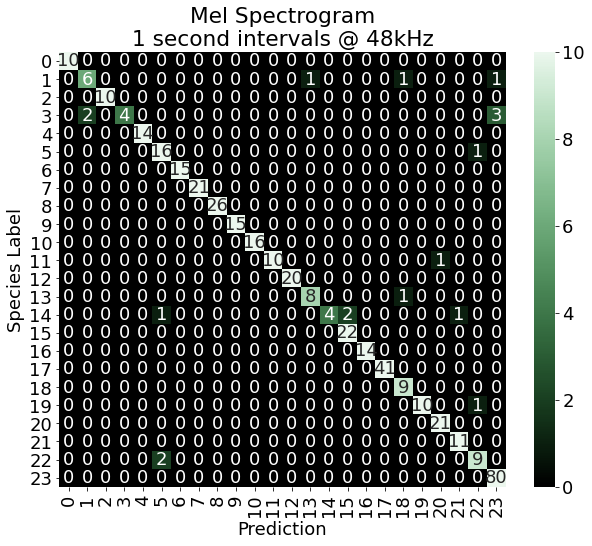

In [153]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))

gr_cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)

sns.heatmap(confusion_mtx, 
            xticklabels=unique_classes, 
            yticklabels=unique_classes, 
            annot=True, 
            cmap=gr_cmap,
            vmin=0,
            vmax=10,
            fmt='g')

plt.title("Mel Spectrogram\n1 second intervals @ 48kHz")
plt.xlabel('Prediction')
plt.ylabel('Species Label')
# plt.savefig(fname='../img/mel_1_sec_confusion_matrix.jpg')
plt.show()

# Classification Report

- [classification_report: Scikit Learn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)  

In [154]:
from sklearn.metrics import classification_report

In [155]:
print(
classification_report(y_true, y_pred, 
                      labels=None, 
                      target_names=None, 
                      sample_weight=None, 
                      digits=2, 
                      output_dict=False, 
                      zero_division='warn')
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.75      0.67      0.71         9
           2       1.00      1.00      1.00        10
           3       1.00      0.44      0.62         9
           4       1.00      1.00      1.00        14
           5       0.84      0.94      0.89        17
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        21
           8       1.00      1.00      1.00        26
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        16
          11       1.00      0.91      0.95        11
          12       1.00      1.00      1.00        20
          13       0.89      0.89      0.89         9
          14       1.00      0.50      0.67         8
          15       0.92      1.00      0.96        22
          16       1.00      1.00      1.00        14
          17       1.00    

In [157]:
pwd

'/Users/christopherkeech/coding_projects/dsi_remote_pt/capstones/rainforest_audio/notebooks'

In [158]:
ls ../data/saved_models

cnn_1_1000_epochs/       cnn_sub_2/
cnn_sub_1/               mel_1_sec_model_(95acc)/


# Preserve mel_1_sec_(96acc) Model

In [161]:
# # # Save the entire model as a SavedModel.
# # !mkdir -p ../data/saved_models/mel_1_sec_model
# tp_model.save('../data/saved_models/mel_1_sec_model_(96acc)/mel_1_sec_96_model')

INFO:tensorflow:Assets written to: ../data/saved_models/mel_1_sec_model_(96acc)/mel_1_sec_96_model/assets
